In [2]:

import math

import numpy as np
import pandas as pd
import datetime
from datetime import datetime  
import csv
import os
from os import listdir
import json
import csv
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras import regularizers ,optimizers
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import tree
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from scipy.spatial import distance
np.random.seed(2018)

In [3]:

def computeDay(group):
  group = group.sort_values('date', ascending=False)    
  group['DayToFailure'] = list(range(0, group.shape[0])) 
  # group = group.sort_values('date')
  return group

def computeDay1(group):
  group = group.sort_values('date')
  return group


def divideInLevel(x):
  global old_distance

  if x.DayToFailure == 0:
    old_distance = x.copy()

    euclidean_distance = 0
  else:
    sum_of_squares = sum([ (old_distance[key]-val) ** 2 for key, val in x.items() if key not in ('date','serial_number', 'Label')])
    # sum_of_squares = sum_of_squares - 0.9*(old_distance.DayToFailure-x.DayToFailure) ** 2
    euclidean_distance = math.sqrt(sum_of_squares)

  old3 = x.DayToFailure
  if x.Label == 0:
    return 'Good'  # Good
  elif euclidean_distance <= 9:

    old4 = old_distance.DayToFailure
    return 'Alert' # Alert
  elif euclidean_distance <= 21:
    return 'Warning '  # Warning
  else:
    return 'Very Fair'


def tolerance_acc(x):
  if x.pred == 'c_Good':
    return x.vero == 'c_Good' or x.vero == 'c_Very Fair'
  
  if x.pred == 'c_Very Fair':
    return x.vero == 'c_Good' or x.vero == 'c_Very Fair' or x.vero == 'c_Warning'
  
  if x.pred == 'c_Warning':
    return  x.vero == 'c_Very Fair' or x.vero == 'c_Warning' or x.vero == 'c_Alert' 
  
  if x.pred == 'c_Alert':
    return  x.vero == 'c_Warning' or x.vero == 'c_Alert' 


def binary_classification_pred(x):
  if x.pred == 'c_Good'  or x.pred == 'c_Very Fair':
    return 0
  else:
    return 1
    
  
def binary_classification_label(x):
  if x.vero == 'c_Good'  or x.vero == 'c_Very Fair':
    return 0
  else:
    return 1


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

  n_vars = data.shape[1]
  cols, names = list(), list()
  dataclass = data[data.columns[-1:]]
  data = data.drop(columns= ['serial_number', 'Class'], axis = 1)
  columns = data.columns
  # input sequence (t-n, ... t-1)  #non arrivo all'osservazione corrente
  for i in range(n_in-1, 0, -1):
    cols.append(data.shift(i))
    names += [(element + '(t-%d)' % (i)) for element in columns]
    
  for i in range(0, n_out):
    cols.append(data.shift(-i))
    if i == 0:
      names += [(element+'(t)') for element in columns]
    else:
      names += [(element +'(t+%d)' % (i)) for element in columns]
  
  cols.append(dataclass)   #appendo le ultime cinque colonne
  names += ['Class']
    
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  if dropnan:
    agg.dropna(inplace=True)
    # agg.fillna(data.median())
  
  return agg


def balancing_by_replication(X_train):
  
  alert = X_train[X_train.c_Alert == 1] 
  vfair = X_train[X_train['c_Very Fair'] == 1]
  warn =  X_train[X_train.c_Warning == 1]
  #'c_Alert','c_Good','c_Very Fair','c_Warning'
  good = X_train[X_train.c_Good == 1] # sono i buoni

  size_good = good.shape[0]

  while alert.shape[0] < size_good:
    app = alert.sample(min(alert.shape[0], size_good - alert.shape[0]), replace=False)
    alert = alert.append(app)

  while vfair.shape[0] < size_good:
    app = vfair.sample(min(vfair.shape[0], size_good - vfair.shape[0]), replace=False)
    vfair = vfair.append(app)
  
  while warn.shape[0] < size_good:
    app = warn.sample(min(warn.shape[0], size_good - warn.shape[0]), replace=False)
    warn = warn.append(app)

  
  good = good.append(alert)
  good = good.append(vfair)
  good = good.append(warn)
  return good 



In [4]:

listLabels = ['c_Alert','c_Good','c_Very Fair','c_Warning']
finestra = 14
df= pd.read_csv('BalckDaUsare.csv',sep=';')
df.date = pd.to_datetime(df.date, format='%Y-%m-%d').dt.date
df = df.drop(['CurrentPendingSectorCount','ReallocatedSectorsCount'], axis=1)

scaler = MinMaxScaler(feature_range = (-1,1))
df[['ReportedUncorrectableErrors', 'HighFlyWrites', 'TemperatureCelsius', 
    'RawCurrentPendingSectorCount','RawReadErrorRate', 'SpinUpTime', 
    'RawReallocatedSectorsCount', 'SeekErrorRate', 'PowerOnHours']] = scaler.fit_transform(df[['ReportedUncorrectableErrors', 
                                                                                               'HighFlyWrites', 'TemperatureCelsius', 
                                                                                               'RawCurrentPendingSectorCount',
                                                                                               'RawReadErrorRate', 'SpinUpTime', 
                                                                                               'RawReallocatedSectorsCount', 
                                                                                               'SeekErrorRate', 'PowerOnHours']])

dfHour = df.groupby(['serial_number']).apply(computeDay)
dfHour = dfHour[dfHour.DayToFailure <= 45]

dfHour['Class'] = dfHour.apply(divideInLevel, axis=1)
dfHour = dfHour.drop(columns=['serial_number'])  
dfHour = dfHour.reset_index()  
# dfHour = dfHour.drop(columns=['serial_number'])  #
dfHour = dfHour.groupby('serial_number').apply(computeDay1)
dfHour = dfHour.drop(columns = ['date'])
dfHour= dfHour.drop(columns= ['Label','DayToFailure'], axis=1)
# dfHour=dfHour.reset_index()
dfHour= dfHour.drop(columns= ['level_1'], axis=1)


#creo le sequenze
print('Creazione Sequenze')
dfHour = dfHour.drop(columns=['serial_number'])
dfHour = dfHour.reset_index()  
dfHour= dfHour.drop(columns= ['level_1'], axis=1)
dfHourSequence =  dfHour.groupby(['serial_number']).apply(series_to_supervised, n_in=finestra, n_out=1, dropnan=True)
dfHourSequence = pd.concat([dfHourSequence, pd.get_dummies(dfHourSequence.Class,prefix='c')], axis=1).drop(['Class'],axis=1)
numberClasses = len(listLabels)
# dfHourSequence = dfHourSequence.drop(columns=['level_1(t-13)'], axis=1)

Creazione Sequenze


In [5]:

#divisione in train validation e split
X_train, X_rim, y_train, y_rim = train_test_split(dfHourSequence[dfHourSequence.columns[:-numberClasses]], 
                                                  dfHourSequence[dfHourSequence.columns[-numberClasses:]] ,
                                                  stratify=dfHourSequence[dfHourSequence.columns[-numberClasses:]], 
                                                  test_size=0.30,
                                                 random_state=0)

print(y_train.sum())
print(y_train.columns)
del dfHourSequence
del dfHour


X_val, X_test, y_val, y_test = train_test_split(X_rim, y_rim ,stratify=y_rim, test_size=0.50)


del X_rim
del y_rim
X_train = pd.concat([X_train, pd.DataFrame(columns = listLabels)], sort = True)
X_val = pd.concat([X_val,  pd.DataFrame(columns = listLabels)], sort = True)
X_test = pd.concat([X_test, pd.DataFrame(columns = listLabels)], sort = True)

X_train[listLabels] = y_train.values
X_val[listLabels] = y_val.values
X_test[listLabels] = y_test.values


del y_train
del y_val
del y_test



print('Balancing')
Complete_train  = balancing_by_replication(X_train)
print(Complete_train.shape)
del X_train

print(X_val.groupby(listLabels).count())
Complete_val = balancing_by_replication(X_val)
print(Complete_val.shape)
del X_val

#tolgo le label
ytrain = Complete_train[listLabels].values
print(Complete_train[listLabels].sum())
Xtrain = Complete_train.drop(columns=listLabels, axis=1 )


yVal = Complete_val[listLabels].values
print(Complete_val[listLabels].sum())
Xval = Complete_val.drop(columns=listLabels, axis=1 )

yTest = X_test[listLabels].values
Xtest = X_test.drop(columns=listLabels, axis=1 )


#reshape come sequenze
Xtrain = Xtrain.values.reshape(Xtrain.shape[0], finestra, int(Xtrain.shape[1]/finestra))
Xval = Xval.values.reshape(Xval.shape[0], finestra, int(Xval.shape[1]/finestra))
Xtest= Xtest.values.reshape(Xtest.shape[0], finestra, int(Xtest.shape[1]/finestra))

print(Xtrain.shape)
print(Xval.shape)
print(Xtest.shape)

print(ytrain.shape)
print(yVal.shape)
print(yTest.shape)




c_Alert         1028
c_Good         63880
c_Very Fair     1178
c_Warning       1284
dtype: int64
Index(['c_Alert', 'c_Good', 'c_Very Fair', 'c_Warning '], dtype='object')
Balancing
(255520, 130)
                                      HighFlyWrites(t)  HighFlyWrites(t-1)  \
c_Alert c_Good c_Very Fair c_Warning                                         
0       0      0           1                       275                 275   
               1           0                       253                 253   
        1      0           0                     13689               13689   
1       0      0           0                       220                 220   

                                      HighFlyWrites(t-10)  \
c_Alert c_Good c_Very Fair c_Warning                        
0       0      0           1                          275   
               1           0                          253   
        1      0           0                        13689   
1       0      0           0   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 14, 256)          141312    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 4)                 1028      
                                                                 
Total params: 536,580
Trainable params: 536,580
Non-trai

D:\Users\su\miniconda3\envs\py37\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch {0}
512/512 [==============================] - 93s 172ms/step - loss: 1.1310 - accuracy: 0.4430 - val_loss: 1.0839 - val_accuracy: 0.4269
Update best model
Epoch {1}
512/512 [==============================] - 89s 174ms/step - loss: 1.0515 - accuracy: 0.4813 - val_loss: 1.0555 - val_accuracy: 0.4544
Update best model
Epoch {2}
512/512 [==============================] - 90s 175ms/step - loss: 0.9100 - accuracy: 0.5789 - val_loss: 0.8783 - val_accuracy: 0.5892
Update best model
Epoch {3}
512/512 [==============================] - 88s 173ms/step - loss: 0.6244 - accuracy: 0.7411 - val_loss: 0.9298 - val_accuracy: 0.6004
Update best model
Epoch {4}
512/512 [==============================] - 86s 169ms/step - loss: 0.3780 - accuracy: 0.8617 - val_loss: 0.6867 - val_accuracy: 0.7098
Update best model
Epoch {5}
512/512 [==============================] - 88s 172ms/step - loss: 0.2184 - accuracy: 0.9314 - val_loss: 0.4753 - val_accuracy: 0.8140
Update best model
Epoch {6}
512/512 [=========

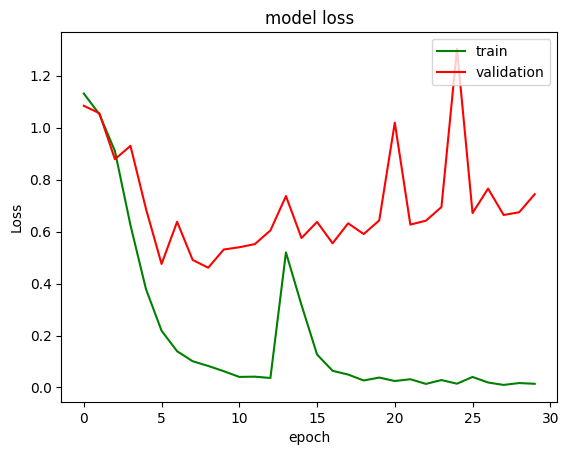

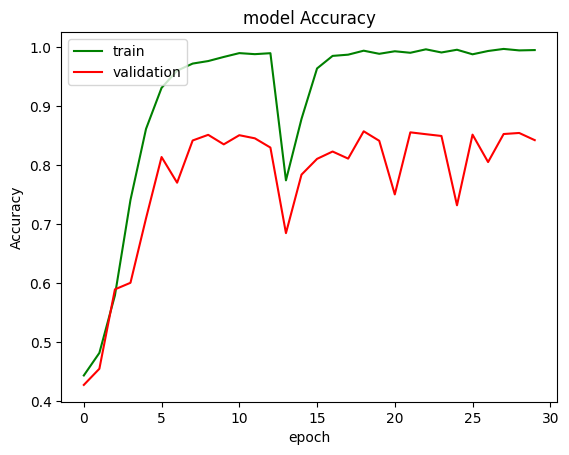

In [6]:
from keras.layers import Dense, Bidirectional, Dropout

def build_model():
  dp_lvl = 0.5
  model = Sequential()
  model.add(Bidirectional(LSTM(128, input_shape=(finestra, 9), return_sequences=True)))
  model.add(Dropout(dp_lvl))
  model.add(Bidirectional(LSTM(128, return_sequences=False)))
  model.add(Dropout(dp_lvl))
  model.add(Dense(numberClasses, activation='softmax'))
  return model


sample_counts = np.array([1, 2, 1, 1])
class_weight = 0.2*sample_counts.sum() / (sample_counts * sample_counts.shape[0])



from keras import backend as K
from keras.regularizers import l2

model = build_model()  
model.build(input_shape=(None, finestra, 9))  
model.summary()

# #Addestramento
def weighted_categorical_crossentropy(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  weights = tf.reduce_sum(class_weight * y_true, axis=-1)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
  l2_loss = l2(0.01)(model.layers[-1].kernel)
  loss = tf.reduce_mean(cross_entropy_loss * weights) + l2_loss
  return loss


model.compile(loss=weighted_categorical_crossentropy_with_l2, optimizer=adam, metrics=['accuracy'])


adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
# model.compile(loss=custom_loss, optimizer=adam, metrics=['accuracy'])
model.compile(loss=weighted_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

epoche = 100
historyvet = []
# model = build_model()
best_acc = 0.0


for epoch in range(0,epoche):
  print('Epoch {%d}' %(epoch))
  history = model.fit(Xtrain, ytrain, epochs=1, batch_size=500, validation_data= (Xval,yVal), shuffle=True)
  if (history.history['val_accuracy'][0] > best_acc ):
    print('Update best model')
    best_acc = history.history['val_accuracy'][0]
    best_epoch  = epoch
    model.save(r'model/Bi_Dis_lstm/{%d}best_model.h5'%(epoch))
    model.save(r'model/Bi_Dis_lstm/best_model.h5')
    
  historyvet.append(history.history)


# #Plot

lossTrain=[]
lossval=[]
accTrain = []
accVal =[]

for element in historyvet:
   lossTrain.append(element['loss'][0])
   lossval.append(element['val_loss'][0])
   accTrain.append(element['accuracy'][0])
   accVal.append(element['val_accuracy'][0])
  

plt.plot(lossTrain, color='g')
plt.plot(lossval, color='r')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(accTrain, color='g')
plt.plot(accVal, color='r')
plt.title('model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()




Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirecti  (None, 14, 256)          141312    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 14, 256)           0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 536,580
Trainable params: 536,580
Non-t

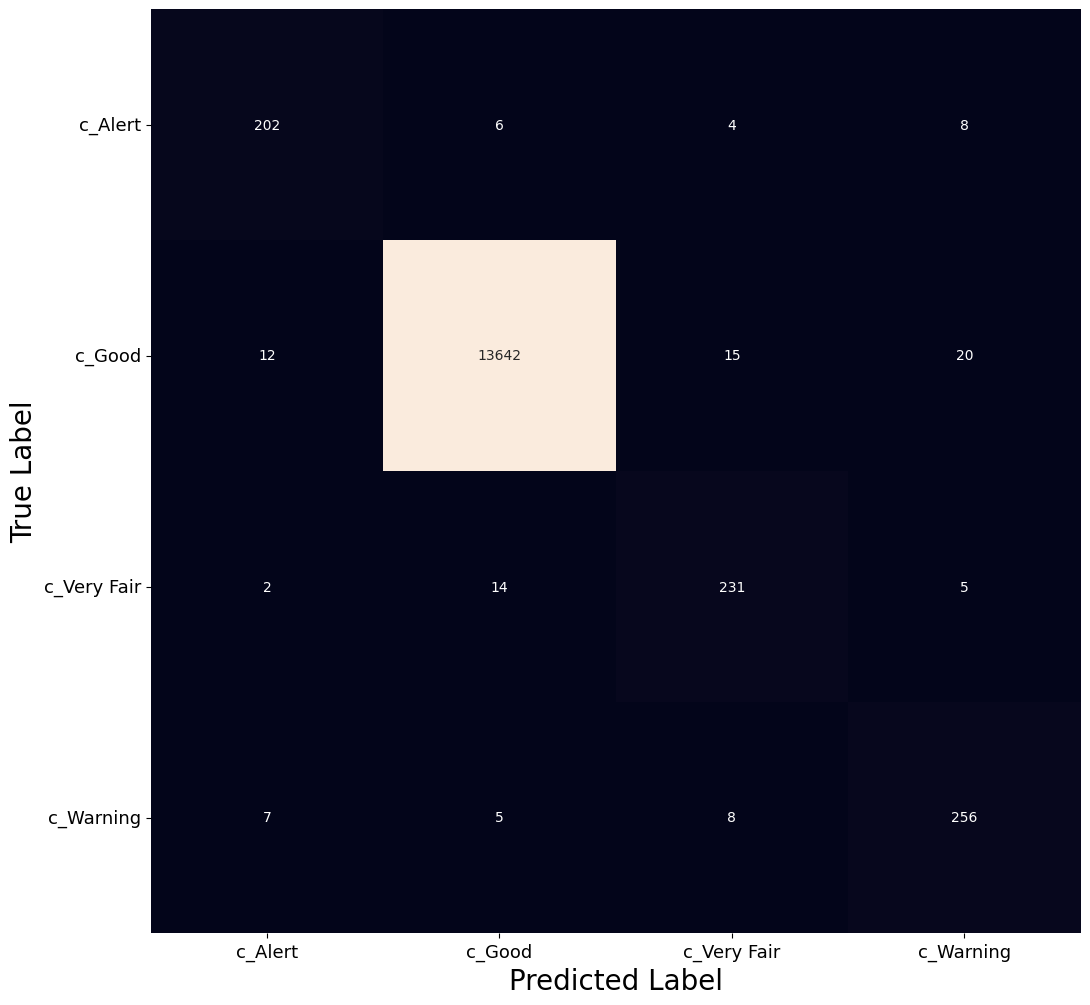

In [38]:

# #Fine tuning on val


newModel = load_model( r'model/Bi_Dis_lstm/best_model.h5')
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
newModel.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
newModel.summary()
epoche = 25

historyRiadd = newModel.fit(Xval,yVal, epochs=epoche, batch_size=1024, shuffle=True)
newModel.save(r'model/Bi_Dis_lstm/Final_model.h5')


# #Performance evaluation



print(newModel.evaluate(Xtest,yTest))



newModel = load_model( r'model/Bi_Dis_lstm/Final_model.h5')

pred = newModel.predict(Xtest)
print(pred.shape)
predpd = pd.DataFrame(pred, columns=listLabels)
print(predpd.idxmax(axis=1))
predpd= predpd.idxmax(axis=1)
predpd = predpd.to_frame()

ytestpd = pd.DataFrame(yTest, columns=listLabels)
ytestpd= ytestpd.idxmax(axis=1)

from sklearn import metrics

acc2 = accuracy_score(ytestpd.values, predpd.values)
print('Accuracy sul Test :', acc2)

print('confusion_matrix:')
confm = metrics.confusion_matrix(ytestpd.values, predpd.values)
print(confm)
cm = confm.astype('float') / confm.sum(axis=1)[:, np.newaxis]

np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
print(cm)

print('confusion_matrix:')
confm = metrics.confusion_matrix(ytestpd.values, predpd.values)
print(confm)

print( metrics.accuracy_score(ytestpd, predpd))
print( metrics.precision_score(ytestpd, predpd, average=None))
print( metrics.recall_score(ytestpd, predpd, average=None))
print(metrics.f1_score(ytestpd, predpd, average=None))

print('accuracy_score: ')
print(metrics.accuracy_score(ytestpd.values, predpd.values))
print('precision_score: ')
print(metrics.precision_score(ytestpd.values, predpd.values, average='weighted'))
print('recall_score: ')
print(metrics.recall_score(ytestpd.values, predpd.values, average='macro'))
print(metrics.recall_score(ytestpd.values, predpd.values, average='micro'))
print('f1_score: ')
print(metrics.f1_score(ytestpd.values, predpd.values, average='weighted'))
# TN, FP, FN, TP = confm[0,0], confm[0,1], confm[1,0], confm[1,1]
FP = confm.sum(axis=0) - np.diag(confm)
FN = confm.sum(axis=1) - np.diag(confm)
TP = np.diag(confm)
TN = confm.sum() - (FP + FN + TP)
hh = (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)

print('FPR : ', FP / (FP + TN))
print('FNR : ', FN / (FN + TP))
MCC = (TP * TN - FP * FN) / np.sqrt(hh)
print('MCC: ', MCC)

c = confusion_matrix(ytestpd.values, predpd.values)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(c, yticklabels=1, xticklabels=1, annot=True, fmt="d", cbar=False)
ax.figure.axes[-1].yaxis.label.set_size(20)
ax.set_xlabel("Predicted Label", fontsize=20)
ax.set_ylabel("True Label", fontsize=20)
ax.tick_params(labelsize=13)
ax.set_xticklabels(listLabels)
ax.set_yticklabels(listLabels)
plt.yticks(rotation=0)

# In[60]:


predpd = predpd.rename(columns={predpd.columns[0]: 'pred'})
predpd['vero'] = ytestpd.values

buoni = predpd[predpd.vero == 'c_Good']
acc3 = accuracy_score(buoni.vero.values, buoni.pred.values)
print('Accuracy sulle sequenze good: ', acc3)

failed = predpd[predpd.vero != 'c_Good']
acc3 = accuracy_score(failed.vero.values, failed.pred.values)
print('Accuracy sulle sequenze failed: ', acc3)

predpd['TOL'] = predpd.apply(tolerance_acc, axis=1)
predpd['TOL'] = predpd['TOL'].astype(int)

buoni = predpd[predpd.vero == 'c_Good']
prest = buoni.TOL.sum() / buoni.shape[0]
print('Accuracy sulle sequenze good con tolleranza: ', prest)

failed = predpd[predpd.vero != 'c_Good']
prest = failed.TOL.sum() / failed.shape[0]
print('Accuracy sulle sequenze failed con tolleranza: ', prest)

# In[61]:


predpd['binaryLabelPred'] = predpd.apply(binary_classification_pred, axis=1)
predpd['binaryLabelTrue'] = predpd.apply(binary_classification_label, axis=1)

# In[62]:


x = predpd[predpd.binaryLabelTrue == 1].binaryLabelTrue.count()
y = predpd[(predpd.binaryLabelTrue == 1) & (predpd.binaryLabelPred == 1)].binaryLabelTrue.count()

FDR = y / x
print('FDR ', FDR)

x = predpd[predpd.binaryLabelTrue == 0].binaryLabelTrue.count()
y = predpd[(predpd.binaryLabelTrue == 0) & (predpd.binaryLabelPred == 1)].binaryLabelTrue.count()

FAR = y / x
print('FAR ', FAR)
